# Guiding questions

What fields of study are international students in the U.S. entering?

In [13]:
from collections import defaultdict
from fuzzywuzzy import fuzz, process
from bs4 import BeautifulSoup, Tag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [123]:
fields = [
    'agriculture',
    'business and management',
    'communications and journalism',
    'education',
    'engineering',
    'fine and applied arts',
    'health professions',
    'humanities',
    'intensive english',
    'legal studies and law enforcement',
    'math and computer science',
    'physical and life sciences',
    'social sciences',
]
years = [y for y in range(1999, 2015)]

In [124]:
def getYearTable(year):
    r = requests.get(
        'https://www.iie.org/Research-and-Insights/Open-Doors/Data/International-Students' + 
        f'/Fields-of-Study/Fields-of-Study/{year}-{str(year+2)[-2 if year > 1999 else 0:]}'
    )
    table = BeautifulSoup(r.content).table
    table.tr.decompose()
    df = pd.read_html(str(table))[0]
    columns = df.iloc[0].str.lower()
    columns[1] = 'population' # rename column we want to Population
    df.columns = columns
    df = df.reindex(df.index.drop(0))
    df = df.dropna(subset=['field of study']) # drop columns with NaN fields
    df['field of study'] = df['field of study'].str.lower().str.replace(', total', '')
    return df

In [126]:
fieldPopulations = {f: [] for f in fields}

for field in fields:
    for year in years:
        table = getYearTable(year)
        tabl

for year in years:
    table = getYearTable(year)
    tableFields = list(table['field of study'].unique())
    for field in fields:
        match, score = process.extractOne(field, tableFields, scorer=fuzz.partial_ratio)
        if score <= 84:
            print(f'{field}\t{match} ({score})')

=== 1999 ===
communications and journalism	education (78)
fine and applied arts	fine & applied arts (84)
legal studies and law enforcement	undeclared (50)
math and computer science	mathematics & computer sciences (84)
=== 2000 ===
communications and journalism	education (78)
fine and applied arts	fine & applied arts (84)
legal studies and law enforcement	undeclared (50)
math and computer science	mathematics & computer sciences (84)
=== 2001 ===
communications and journalism	education (78)
fine and applied arts	fine & applied arts (84)
legal studies and law enforcement	undeclared (50)
math and computer science	mathematics & computer sciences (84)
=== 2002 ===
communications and journalism	education (78)
fine and applied arts	fine & applied arts (84)
legal studies and law enforcement	undeclared (50)
math and computer science	mathematics & computer sciences (84)
=== 2003 ===
=== 2004 ===
legal studies and law enforcement	business and management (65)
=== 2005 ===
legal studies and law enfo

In [3]:
# @param year Two-digit year of the 21st century
def getFieldPopulations(year):
    if year < 1999 or year > 2014:
        print('Year must be between 1999 and 2014.')
        return None

    r = requests.get(
        f'https://www.iie.org/Research-and-Insights/Open-Doors/Data/International-Students/Fields-of-Study/Fields-of-Study/{year}-{year + 2 if year < 2000 else str(year + 2)[-2:]}'
    )
    table = BeautifulSoup(r.content).table
    table.tr.decompose() # delete first row
    headers = table.tr.findAll('td')
    hdIndex = None
    for index, header in reversed(list(enumerate(headers))):
        if '%' not in str(header):
            hdIndex = index
            break

    others = ['LEGAL PROFESSIONS AND STUDIES', 'COMMUNICATION, JOURNALISM, AND RELATED PROGRAMS', 'COMMUNICATION, JOURNALISM', 'COMMUNICATIONS AND JOURNALISM']
    exceptions = ['INTENSIVE ENGLISH LANGUAGE', 'EDUCATION', 'HEALTH PROFESSIONS', 'HEALTH PROFESSIONS (2)', 'FINE AND APPLIED ARTS', 'UNDECLARED', 'TOTAL', 'TOTAL INTERNATIONAL STUDENTS']

    format2Years = listRange(2003, 2008)
    format3Years = listRange(1999, 2003) + listRange(2008, 2012)
    format4Years = listRange(2012, 2014)

    fieldPop = {}

    for tr in table.findAll('tr')[1:]:
        field = tr.td
        if field is None or field.string is None:
            continue
        elif year in format2Years:
            field.string = field.string.upper()
            if ', TOTAL' in field.string or field.string in exceptions or field.string in others:
                field.string = field.string.replace(', TOTAL', '')
            else:
                continue
        elif year in format3Years:
            field.string = field.string.upper().replace(', TOTAL', '')
        elif year in format4Years:
            if field.strong or field.string.upper() in exceptions or field.string.upper() in others:
                field.string = field.string.upper()
            else:
                continue
        else:
            if field.strong:
                field.string = field.string.upper()
            else:
                continue

        dataStr = tr.findAll('td')[hdIndex].string
        if field is not None and len(field.string or '') > 1:
            fieldPop[str(field.string)] = int(dataStr.replace(',', ''))
        
    if year in format2Years or year in format4Years:
        for o in others:
            if 'OTHER' in fieldPop:
                fieldPop['OTHER'] -= fieldPop.get(o, 0)
            elif 'OTHER FIELDS OF STUDY' in fieldPop:
                fieldPop['OTHER FIELDS OF STUDY'] -= fieldPop.get(o, 0)
        
    return fieldPop

In [4]:
tables = {} # key = academic year, value = international student counts

for year in range(1999, 2015):
    tables[year + 1] = getFieldPopulations(year)
    print(f'Successfully scanned {year + 1} data.')

Successfully scanned 2000 data.
Successfully scanned 2001 data.
Successfully scanned 2002 data.
Successfully scanned 2003 data.
Successfully scanned 2004 data.
Successfully scanned 2005 data.
Successfully scanned 2006 data.
Successfully scanned 2007 data.
Successfully scanned 2008 data.
Successfully scanned 2009 data.
Successfully scanned 2010 data.
Successfully scanned 2011 data.
Successfully scanned 2012 data.
Successfully scanned 2013 data.
Successfully scanned 2014 data.
Successfully scanned 2015 data.


In [5]:
desiredKeys = list(tables[2015].keys())
print(desiredKeys)

['AGRICULTURE', 'BUSINESS AND MANAGEMENT', 'COMMUNICATIONS AND JOURNALISM', 'EDUCATION', 'ENGINEERING', 'FINE AND APPLIED ARTS', 'HEALTH PROFESSIONS', 'HUMANITIES', 'INTENSIVE ENGLISH', 'LEGAL STUDIES AND LAW ENFORCEMENT', 'MATH AND COMPUTER SCIENCE', 'PHYSICAL AND LIFE SCIENCES', 'SOCIAL SCIENCES', 'OTHER FIELDS OF STUDY', 'UNDECLARED', 'TOTAL']


In [6]:
for key in desiredKeys:
    print(f'=== Finding {key} ===')
    for year in tables.keys():
        fuzzyKey = process.extractOne(key, list(tables[year].keys()), scorer=fuzz.partial_ratio)
        print(f'{year}: {fuzzyKey}')

=== Finding AGRICULTURE ===
2000: ('AGRICULTURE', 100)
2001: ('AGRICULTURE', 100)
2002: ('AGRICULTURE', 100)
2003: ('AGRICULTURE', 100)
2004: ('AGRICULTURE', 100)
2005: ('AGRICULTURE', 100)
2006: ('AGRICULTURE', 100)
2007: ('AGRICULTURE', 100)
2008: ('AGRICULTURE', 100)
2009: ('AGRICULTURE', 100)
2010: ('AGRICULTURE', 100)
2011: ('AGRICULTURE', 100)
2012: ('AGRICULTURE', 100)
2013: ('AGRICULTURE', 100)
2014: ('AGRICULTURE', 100)
2015: ('AGRICULTURE', 100)
=== Finding BUSINESS AND MANAGEMENT ===
2000: ('BUSINESS & MANAGEMENT', 86)
2001: ('BUSINESS & MANAGEMENT', 86)
2002: ('BUSINESS & MANAGEMENT', 86)
2003: ('BUSINESS & MANAGEMENT', 86)
2004: ('BUSINESS AND MANAGEMENT', 100)
2005: ('BUSINESS AND MANAGEMENT', 100)
2006: ('BUSINESS AND MANAGEMENT', 100)
2007: ('BUSINESS AND MANAGEMENT', 100)
2008: ('BUSINESS AND MANAGEMENT', 100)
2009: ('BUSINESS AND MANAGEMENT', 100)
2010: ('BUSINESS AND MANAGEMENT', 100)
2011: ('BUSINESS AND MANAGEMENT', 100)
2012: ('BUSINESS AND MANAGEMENT', 100)
2013:

2009: ('UNDECLARED', 100)
2010: ('UNDECLARED', 100)
2011: ('UNDECLARED', 100)
2012: ('UNDECLARED', 100)
2013: ('UNDECLARED', 100)
2014: ('UNDECLARED', 100)
2015: ('UNDECLARED', 100)
=== Finding TOTAL ===
2000: ('TOTAL', 100)
2001: ('TOTAL', 100)
2002: ('TOTAL', 100)
2003: ('TOTAL', 100)
2004: ('TOTAL', 100)
2005: ('TOTAL', 100)
2006: ('TOTAL', 100)
2007: ('TOTAL INTERNATIONAL STUDENTS', 100)
2008: ('TOTAL INTERNATIONAL STUDENTS', 100)
2009: ('TOTAL INTERNATIONAL STUDENTS', 100)
2010: ('TOTAL INTERNATIONAL STUDENTS', 100)
2011: ('TOTAL INTERNATIONAL STUDENTS', 100)
2012: ('TOTAL INTERNATIONAL STUDENTS', 100)
2013: ('TOTAL', 100)
2014: ('TOTAL', 100)
2015: ('TOTAL', 100)


The cutoff looks like a score of 84.

In [8]:
fields = desiredKeys

data = defaultdict(list)
for key in fields:
    for year, table in tables.items():
        fuzzyKey, score = process.extractOne(key, list(table.keys()), scorer=fuzz.partial_ratio)
        if score >= 84:
            data[key].append(table[fuzzyKey])
        else:
            data[key].append(None)

In [11]:
sum([tables[2014][k] for k in tables[2014].keys() if k != 'TOTAL'])

954613

In [12]:
tables[2014]

{'AGRICULTURE': 12278,
 'BUSINESS AND MANAGEMENT': 197258,
 'COMMUNICATIONS AND JOURNALISM': 20161,
 'COMMUNICATION, JOURNALISM': 16964,
 'EDUCATION': 17675,
 'ENGINEERING': 196750,
 'FINE AND APPLIED ARTS': 56758,
 'HEALTH PROFESSIONS': 33247,
 'HUMANITIES': 17504,
 'INTENSIVE ENGLISH': 49233,
 'LEGAL STUDIES AND LAW ENFORCEMENT': 13778,
 'LEGAL PROFESSIONS AND STUDIES': 11776,
 'MATH AND COMPUTER SCIENCE': 112950,
 'PHYSICAL AND LIFE SCIENCES': 73838,
 'SOCIAL SCIENCES': 75951,
 'OTHER FIELDS OF STUDY': 24275,
 'UNDECLARED': 24217,
 'TOTAL': 974926}

In [115]:
years = range(2000, 2016)

stackplot = []
yearTotals = []
for i in range(len(years)):
    yearTotals.append(
        sum( data[f][i] or 0 for f in fields if f != 'TOTAL')
    )

print('Make sure these totals match:')
for i in range(len(years)):
    a, b = yearTotals[i], data['TOTAL'][i]
    print('✅' if a == b else '❌', a, b)

Make sure these totals match:
❌ 547868 547867
❌ 582997 582996
❌ 586321 586323
✅ 572509 572509
❌ 536607 565039
❌ 517118 564766
❌ 532733 582984
❌ 560441 623805
❌ 662916 671616
✅ 690923 690923
✅ 723277 723277
✅ 764495 764495
✅ 819644 819644
❌ 874753 886052
❌ 925873 974926
✅ 1043839 1043839


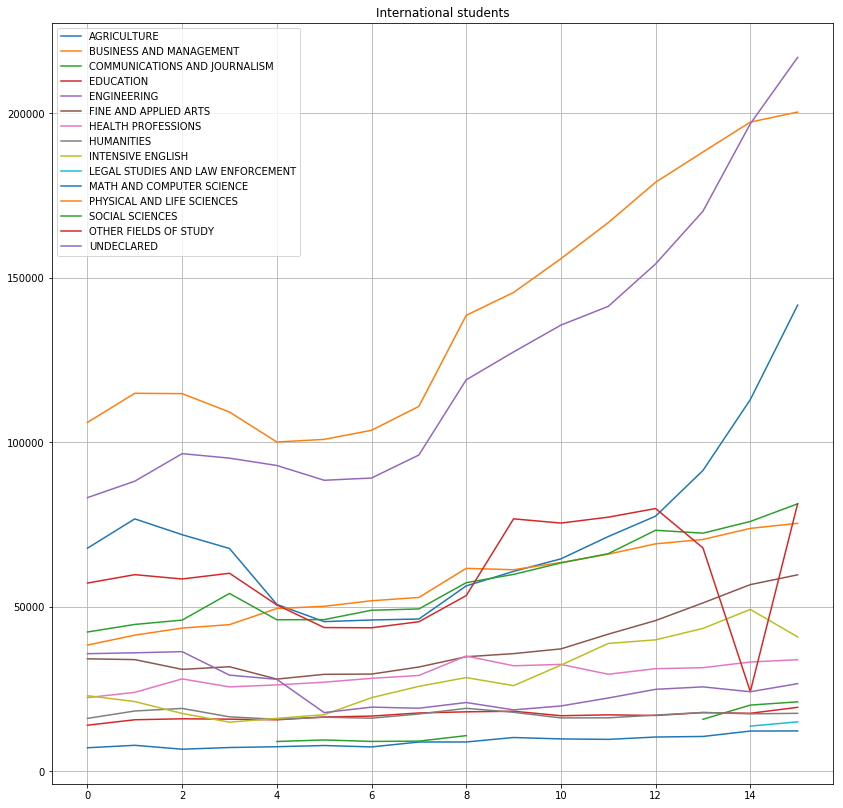

In [72]:
def plotFields(fields, title="International students", legend=False):
    plt.figure(figsize=(14, 14))
    plt.title(title)

    for f in fields:
        plt.plot(data[f], label=f)

    plt.legend()

    plt.grid()
plotFields(fields)

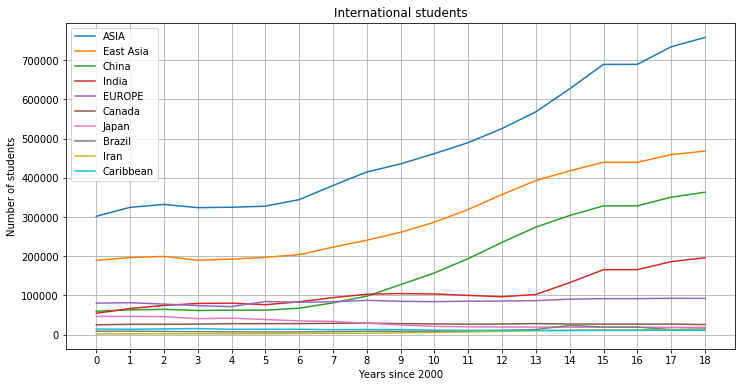

In [31]:
def mostRecent(c):
    try:
        return recent.loc[c]['2017/2018']
    except KeyError:
        return 0

topCountries = sorted(allCountries, key=mostRecent, reverse=True)[:10]
plotCountries(topCountries, legend=True)

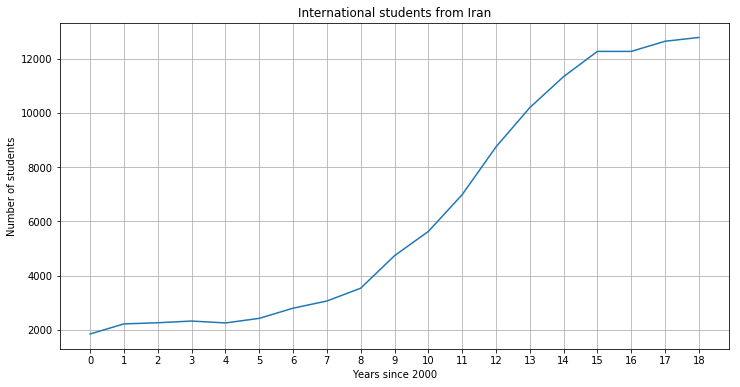

In [32]:
# Hooshmand noted possible stagnation of students from Iran
plotCountries(['Iran'], title="International students from Iran")

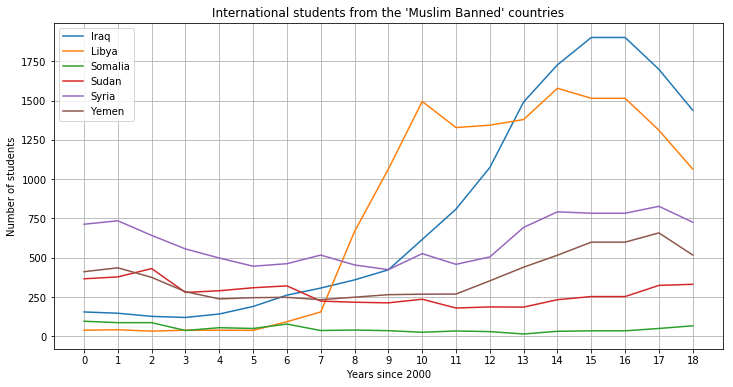

In [33]:
muslimBanCountries = ['Iraq', 'Libya', 'Somalia', 'Sudan', 'Syria', 'Yemen']
plotCountries(muslimBanCountries, title="International students from the 'Muslim Banned' countries", legend=True)

# Findings

International students mostly come from China and India.

There was a stagnation of students from Iran, and a decline in students from most Muslim Ban countries.